<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/AdvancedEmotionNet_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!  pip install kaggle
! pip install wandb
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 99% 283M/285M [00:00<00:00, 391MB/s]
100% 285M/285M [00:00<00:00, 405MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


Using device: cuda
Training data shape: (28709, 2)
Test data shape: (7178, 1)
Unique emotions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion distribution:
0 (Angry): 3995
1 (Disgust): 436
2 (Fear): 4097
3 (Happy): 7215
4 (Sad): 4830
5 (Surprise): 3171
6 (Neutral): 4965


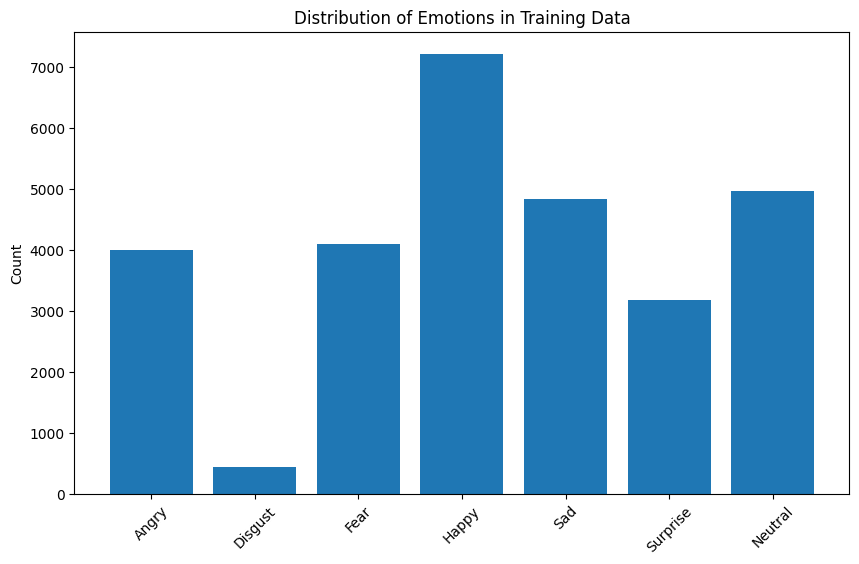

In [16]:
# Cell 1: Setup and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Unique emotions: {sorted(train_df['emotion'].unique())}")

# Check class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nEmotion distribution:")
for i, count in emotion_counts.items():
    print(f"{i} ({emotion_labels[i]}): {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(7), emotion_counts.values)
plt.xticks(range(7), emotion_labels, rotation=45)
plt.title('Distribution of Emotions in Training Data')
plt.ylabel('Count')
plt.show()

In [17]:
# Cell 2: Custom Dataset and Data Transformation
from torchvision import transforms
from PIL import Image # Import PIL Image for torchvision transforms

class FacialExpressionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pixels = df['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(48, 48)).tolist()
        self.emotions = df['emotion'].tolist() if 'emotion' in df.columns else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        image = Image.fromarray(image) # Convert numpy array to PIL Image for torchvision transforms

        if self.transform:
            image = self.transform(image)

        if self.emotions is not None:
            emotion = self.emotions[idx]
            return image, torch.tensor(emotion, dtype=torch.long)
        else:
            return image

class TestTimeAugmentationDataset(Dataset):
    def __init__(self, df, transforms_list):
        self.df = df
        self.transforms_list = transforms_list
        self.pixels = df['pixels'].apply(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(48, 48)).tolist()
        self.emotions = df['emotion'].tolist() if 'emotion' in df.columns else None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        image = Image.fromarray(image)

        # Apply each transform in the list
        transformed_images = [t(image) for t in self.transforms_list]

        if self.emotions is not None:
            emotion = self.emotions[idx]
            return transformed_images, torch.tensor(emotion, dtype=torch.long)
        else:
            return transformed_images


# Define transformations
# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(15), # Increased rotation slightly
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.85, 1.15)), # Slightly increased affine range
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Added color jitter
    transforms.Grayscale(num_output_channels=1), # Ensure grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize pixel values to [-1, 1]
])

# Base transform for validation/test (no augmentation, just normalization)
base_val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Test-Time Augmentation transforms (a list of transforms for TTA)
tta_transforms = [
    base_val_test_transform, # Original
    transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomHorizontalFlip(p=1.0), # Flipped
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(5), # Small rotation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # Small translation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
]

In [18]:
# Cell 3: Data Splitting and DataLoader Creation
# Split training data for validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion'])

# Create datasets
train_dataset = FacialExpressionDataset(train_data, transform=train_transforms)
val_dataset = TestTimeAugmentationDataset(val_data, transforms_list=tta_transforms) # Use TTA for validation
test_dataset = TestTimeAugmentationDataset(test_df, transforms_list=tta_transforms) # Use TTA for test

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 22967
Number of validation samples: 5742
Number of test samples: 7178


In [19]:
# Cell 4: Define the CNN Model
class EnhancedFERNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EnhancedFERNet, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # Increased filters
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2 (Added one more conv layer)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) # New layer
        self.bn5 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Block 3 (Added one more conv layer, increased filters)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) # Increased filters
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) # New layer
        self.bn8 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully Connected Layers
        # 48x48 -> 24x24 (pool1) -> 12x12 (pool2) -> 6x6 (pool3)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x))) # New layer
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x))) # New layer
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        return x

model = EnhancedFERNet(num_classes=7).to(device)
print(model)

EnhancedFERNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPo

In [20]:
# Cell 5: Training Function
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, pred, target):
        n_class = pred.size(1)
        # Convert target to one-hot encoding
        one_hot = F.one_hot(target, n_class).float().to(pred.device)
        # Apply label smoothing
        one_hot = one_hot * (1 - self.epsilon) + self.epsilon / n_class
        # Calculate log_probs
        log_probs = F.log_softmax(pred, dim=1)
        # Calculate cross-entropy with smoothed labels
        loss = -(one_hot * log_probs).sum(dim=1)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

def train_model(model, train_loader, val_loader, epochs, learning_rate, patience=10, max_grad_norm=1.0):
    criterion = LabelSmoothingCrossEntropy(epsilon=0.1) # Using Label Smoothing
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-6) # Added min_lr

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validation phase with TTA
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images_list, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} (Val with TTA)"):
                labels = labels.to(device)

                # Aggregate predictions from TTA
                tta_outputs = []
                for img_transformed in images_list:
                    img_transformed = img_transformed.to(device)
                    tta_outputs.append(model(img_transformed))

                # Average the logits or probabilities
                avg_outputs = torch.stack(tta_outputs).mean(dim=0) # Average logits

                loss = criterion(avg_outputs, labels) # Calculate loss using averaged outputs
                val_loss += loss.item()

                _, predicted = torch.max(avg_outputs, 1)
                all_val_preds.extend(predicted.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = accuracy_score(all_val_labels, all_val_preds) # Use accuracy_score for TTA

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Learning rate scheduler step
        scheduler.step(epoch_val_acc)

        # Early stopping check
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth') # Save the best model
            print("Best validation accuracy achieved. Model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break
    return history

In [21]:
# Cell 6: Run Training
epochs = 70
learning_rate = 0.001

print(f"Starting training for {epochs} epochs with learning rate {learning_rate}...")
model = EnhancedFERNet(num_classes=7).to(device) # Re-initialize model to apply new architecture
history = train_model(model, train_loader, val_loader, epochs, learning_rate, patience=15) # Increased patience

Starting training for 70 epochs with learning rate 0.001...


Epoch 1/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.04it/s]


Epoch 1/70 - Train Loss: 1.8683, Train Acc: 0.2503, Val Loss: 1.7132, Val Acc: 0.3236
Best validation accuracy achieved. Model saved.


Epoch 2/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.09it/s]


Epoch 2/70 - Train Loss: 1.7049, Train Acc: 0.3529, Val Loss: 1.5548, Val Acc: 0.4385
Best validation accuracy achieved. Model saved.


Epoch 3/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.09it/s]


Epoch 3/70 - Train Loss: 1.5670, Train Acc: 0.4336, Val Loss: 1.4176, Val Acc: 0.5111
Best validation accuracy achieved. Model saved.


Epoch 4/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 12.97it/s]


Epoch 4/70 - Train Loss: 1.5017, Train Acc: 0.4676, Val Loss: 1.3740, Val Acc: 0.5331
Best validation accuracy achieved. Model saved.


Epoch 5/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.65it/s]


Epoch 5/70 - Train Loss: 1.4654, Train Acc: 0.4907, Val Loss: 1.3454, Val Acc: 0.5505
Best validation accuracy achieved. Model saved.


Epoch 6/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.89it/s]


Epoch 6/70 - Train Loss: 1.4336, Train Acc: 0.5086, Val Loss: 1.3323, Val Acc: 0.5545
Best validation accuracy achieved. Model saved.


Epoch 7/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.31it/s]


Epoch 7/70 - Train Loss: 1.4088, Train Acc: 0.5233, Val Loss: 1.3161, Val Acc: 0.5676
Best validation accuracy achieved. Model saved.


Epoch 8/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 10.98it/s]


Epoch 8/70 - Train Loss: 1.3857, Train Acc: 0.5361, Val Loss: 1.3576, Val Acc: 0.5474


Epoch 9/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.19it/s]


Epoch 9/70 - Train Loss: 1.3670, Train Acc: 0.5506, Val Loss: 1.2647, Val Acc: 0.5933
Best validation accuracy achieved. Model saved.


Epoch 10/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.72it/s]


Epoch 10/70 - Train Loss: 1.3518, Train Acc: 0.5537, Val Loss: 1.2720, Val Acc: 0.5947
Best validation accuracy achieved. Model saved.


Epoch 11/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.11it/s]


Epoch 11/70 - Train Loss: 1.3340, Train Acc: 0.5627, Val Loss: 1.2454, Val Acc: 0.6059
Best validation accuracy achieved. Model saved.


Epoch 12/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.81it/s]


Epoch 12/70 - Train Loss: 1.3231, Train Acc: 0.5706, Val Loss: 1.2439, Val Acc: 0.6134
Best validation accuracy achieved. Model saved.


Epoch 13/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.59it/s]


Epoch 13/70 - Train Loss: 1.3083, Train Acc: 0.5814, Val Loss: 1.2403, Val Acc: 0.6061


Epoch 14/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.08it/s]


Epoch 14/70 - Train Loss: 1.2978, Train Acc: 0.5848, Val Loss: 1.2135, Val Acc: 0.6186
Best validation accuracy achieved. Model saved.


Epoch 15/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.24it/s]


Epoch 15/70 - Train Loss: 1.2874, Train Acc: 0.5892, Val Loss: 1.2253, Val Acc: 0.6109


Epoch 16/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.10it/s]


Epoch 16/70 - Train Loss: 1.2731, Train Acc: 0.5965, Val Loss: 1.2119, Val Acc: 0.6271
Best validation accuracy achieved. Model saved.


Epoch 17/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.13it/s]


Epoch 17/70 - Train Loss: 1.2651, Train Acc: 0.6006, Val Loss: 1.1835, Val Acc: 0.6341
Best validation accuracy achieved. Model saved.


Epoch 18/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.74it/s]


Epoch 18/70 - Train Loss: 1.2584, Train Acc: 0.6047, Val Loss: 1.2099, Val Acc: 0.6296


Epoch 19/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.13it/s]


Epoch 19/70 - Train Loss: 1.2490, Train Acc: 0.6111, Val Loss: 1.1853, Val Acc: 0.6398
Best validation accuracy achieved. Model saved.


Epoch 20/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.28it/s]


Epoch 20/70 - Train Loss: 1.2370, Train Acc: 0.6151, Val Loss: 1.1739, Val Acc: 0.6475
Best validation accuracy achieved. Model saved.


Epoch 21/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.12it/s]


Epoch 21/70 - Train Loss: 1.2351, Train Acc: 0.6174, Val Loss: 1.1697, Val Acc: 0.6480
Best validation accuracy achieved. Model saved.


Epoch 22/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.42it/s]


Epoch 22/70 - Train Loss: 1.2294, Train Acc: 0.6184, Val Loss: 1.1764, Val Acc: 0.6393


Epoch 23/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.31it/s]


Epoch 23/70 - Train Loss: 1.2194, Train Acc: 0.6273, Val Loss: 1.1588, Val Acc: 0.6480


Epoch 24/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.08it/s]


Epoch 24/70 - Train Loss: 1.2161, Train Acc: 0.6280, Val Loss: 1.1597, Val Acc: 0.6566
Best validation accuracy achieved. Model saved.


Epoch 25/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.71it/s]


Epoch 25/70 - Train Loss: 1.2051, Train Acc: 0.6334, Val Loss: 1.1510, Val Acc: 0.6621
Best validation accuracy achieved. Model saved.


Epoch 26/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.61it/s]


Epoch 26/70 - Train Loss: 1.1988, Train Acc: 0.6363, Val Loss: 1.1422, Val Acc: 0.6602


Epoch 27/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.33it/s]


Epoch 27/70 - Train Loss: 1.1923, Train Acc: 0.6386, Val Loss: 1.1391, Val Acc: 0.6580


Epoch 28/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.46it/s]


Epoch 28/70 - Train Loss: 1.1910, Train Acc: 0.6423, Val Loss: 1.1533, Val Acc: 0.6526


Epoch 29/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.09it/s]


Epoch 29/70 - Train Loss: 1.1862, Train Acc: 0.6441, Val Loss: 1.1394, Val Acc: 0.6609


Epoch 30/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.01it/s]


Epoch 30/70 - Train Loss: 1.1795, Train Acc: 0.6493, Val Loss: 1.1417, Val Acc: 0.6627
Best validation accuracy achieved. Model saved.


Epoch 31/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.73it/s]


Epoch 31/70 - Train Loss: 1.1713, Train Acc: 0.6495, Val Loss: 1.1316, Val Acc: 0.6674
Best validation accuracy achieved. Model saved.


Epoch 32/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.05it/s]


Epoch 32/70 - Train Loss: 1.1598, Train Acc: 0.6580, Val Loss: 1.1390, Val Acc: 0.6646


Epoch 33/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.28it/s]


Epoch 33/70 - Train Loss: 1.1634, Train Acc: 0.6541, Val Loss: 1.1308, Val Acc: 0.6693
Best validation accuracy achieved. Model saved.


Epoch 34/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.21it/s]


Epoch 34/70 - Train Loss: 1.1519, Train Acc: 0.6616, Val Loss: 1.1269, Val Acc: 0.6688


Epoch 35/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 10.94it/s]


Epoch 35/70 - Train Loss: 1.1560, Train Acc: 0.6606, Val Loss: 1.1290, Val Acc: 0.6703
Best validation accuracy achieved. Model saved.


Epoch 36/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 10.94it/s]


Epoch 36/70 - Train Loss: 1.1481, Train Acc: 0.6626, Val Loss: 1.1219, Val Acc: 0.6743
Best validation accuracy achieved. Model saved.


Epoch 37/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.77it/s]


Epoch 37/70 - Train Loss: 1.1452, Train Acc: 0.6646, Val Loss: 1.1393, Val Acc: 0.6634


Epoch 38/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.81it/s]


Epoch 38/70 - Train Loss: 1.1376, Train Acc: 0.6689, Val Loss: 1.1218, Val Acc: 0.6728


Epoch 39/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.35it/s]


Epoch 39/70 - Train Loss: 1.1285, Train Acc: 0.6732, Val Loss: 1.1350, Val Acc: 0.6693


Epoch 40/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.78it/s]


Epoch 40/70 - Train Loss: 1.1255, Train Acc: 0.6746, Val Loss: 1.1323, Val Acc: 0.6722


Epoch 41/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.13it/s]


Epoch 41/70 - Train Loss: 1.1208, Train Acc: 0.6793, Val Loss: 1.1147, Val Acc: 0.6729


Epoch 42/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.87it/s]


Epoch 42/70 - Train Loss: 1.1193, Train Acc: 0.6804, Val Loss: 1.1103, Val Acc: 0.6804
Best validation accuracy achieved. Model saved.


Epoch 43/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.83it/s]


Epoch 43/70 - Train Loss: 1.1113, Train Acc: 0.6849, Val Loss: 1.1176, Val Acc: 0.6803


Epoch 44/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.74it/s]


Epoch 44/70 - Train Loss: 1.1060, Train Acc: 0.6870, Val Loss: 1.1433, Val Acc: 0.6712


Epoch 45/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.82it/s]


Epoch 45/70 - Train Loss: 1.1022, Train Acc: 0.6859, Val Loss: 1.1163, Val Acc: 0.6768


Epoch 46/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.15it/s]


Epoch 46/70 - Train Loss: 1.0936, Train Acc: 0.6935, Val Loss: 1.1008, Val Acc: 0.6830
Best validation accuracy achieved. Model saved.


Epoch 47/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.27it/s]


Epoch 47/70 - Train Loss: 1.0945, Train Acc: 0.6900, Val Loss: 1.1206, Val Acc: 0.6722


Epoch 48/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.57it/s]


Epoch 48/70 - Train Loss: 1.0847, Train Acc: 0.6984, Val Loss: 1.1094, Val Acc: 0.6815


Epoch 49/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.82it/s]


Epoch 49/70 - Train Loss: 1.0852, Train Acc: 0.6965, Val Loss: 1.1020, Val Acc: 0.6834
Best validation accuracy achieved. Model saved.


Epoch 50/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.94it/s]


Epoch 50/70 - Train Loss: 1.0844, Train Acc: 0.6963, Val Loss: 1.1173, Val Acc: 0.6789


Epoch 51/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.78it/s]


Epoch 51/70 - Train Loss: 1.0794, Train Acc: 0.7006, Val Loss: 1.1158, Val Acc: 0.6752


Epoch 52/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 10.82it/s]


Epoch 52/70 - Train Loss: 1.0709, Train Acc: 0.7026, Val Loss: 1.1201, Val Acc: 0.6792


Epoch 53/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.62it/s]


Epoch 53/70 - Train Loss: 1.0680, Train Acc: 0.7042, Val Loss: 1.1118, Val Acc: 0.6869
Best validation accuracy achieved. Model saved.


Epoch 54/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.50it/s]


Epoch 54/70 - Train Loss: 1.0572, Train Acc: 0.7127, Val Loss: 1.1066, Val Acc: 0.6856


Epoch 55/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.01it/s]


Epoch 55/70 - Train Loss: 1.0576, Train Acc: 0.7120, Val Loss: 1.0989, Val Acc: 0.6836


Epoch 56/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.97it/s]


Epoch 56/70 - Train Loss: 1.0512, Train Acc: 0.7142, Val Loss: 1.1063, Val Acc: 0.6877
Best validation accuracy achieved. Model saved.


Epoch 57/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.59it/s]


Epoch 57/70 - Train Loss: 1.0483, Train Acc: 0.7138, Val Loss: 1.1036, Val Acc: 0.6846


Epoch 58/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.27it/s]


Epoch 58/70 - Train Loss: 1.0385, Train Acc: 0.7211, Val Loss: 1.1248, Val Acc: 0.6809


Epoch 59/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.78it/s]


Epoch 59/70 - Train Loss: 1.0456, Train Acc: 0.7148, Val Loss: 1.1047, Val Acc: 0.6855


Epoch 60/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 14.04it/s]


Epoch 60/70 - Train Loss: 1.0334, Train Acc: 0.7253, Val Loss: 1.0980, Val Acc: 0.6916
Best validation accuracy achieved. Model saved.


Epoch 61/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Epoch 61/70 - Train Loss: 1.0287, Train Acc: 0.7261, Val Loss: 1.1059, Val Acc: 0.6879


Epoch 62/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.70it/s]


Epoch 62/70 - Train Loss: 1.0277, Train Acc: 0.7268, Val Loss: 1.1163, Val Acc: 0.6799


Epoch 63/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.20it/s]


Epoch 63/70 - Train Loss: 1.0245, Train Acc: 0.7273, Val Loss: 1.1041, Val Acc: 0.6886


Epoch 64/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.39it/s]


Epoch 64/70 - Train Loss: 1.0158, Train Acc: 0.7326, Val Loss: 1.1062, Val Acc: 0.6853


Epoch 65/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.65it/s]


Epoch 65/70 - Train Loss: 1.0171, Train Acc: 0.7311, Val Loss: 1.1288, Val Acc: 0.6846


Epoch 66/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.70it/s]


Epoch 66/70 - Train Loss: 1.0154, Train Acc: 0.7337, Val Loss: 1.0912, Val Acc: 0.6933
Best validation accuracy achieved. Model saved.


Epoch 67/70 (Val with TTA): 100%|██████████| 90/90 [00:06<00:00, 13.14it/s]


Epoch 67/70 - Train Loss: 1.0013, Train Acc: 0.7430, Val Loss: 1.0943, Val Acc: 0.6926


Epoch 68/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 11.39it/s]


Epoch 68/70 - Train Loss: 1.0016, Train Acc: 0.7417, Val Loss: 1.1092, Val Acc: 0.6837


Epoch 69/70 (Val with TTA): 100%|██████████| 90/90 [00:08<00:00, 11.06it/s]


Epoch 69/70 - Train Loss: 1.0027, Train Acc: 0.7407, Val Loss: 1.0905, Val Acc: 0.6994
Best validation accuracy achieved. Model saved.


Epoch 70/70 (Val with TTA): 100%|██████████| 90/90 [00:07<00:00, 12.34it/s]

Epoch 70/70 - Train Loss: 0.9971, Train Acc: 0.7408, Val Loss: 1.1056, Val Acc: 0.6917


Evaluating on Validation Set with TTA: 100%|██████████| 90/90 [00:09<00:00,  9.08it/s]



Validation Accuracy (with TTA): 0.6984

Classification Report:
              precision    recall  f1-score   support

       Angry       0.63      0.60      0.62       799
     Disgust       0.88      0.48      0.62        87
        Fear       0.62      0.43      0.51       820
       Happy       0.87      0.90      0.89      1443
         Sad       0.58      0.63      0.60       966
    Surprise       0.79      0.79      0.79       634
     Neutral       0.61      0.72      0.66       993

    accuracy                           0.70      5742
   macro avg       0.71      0.65      0.67      5742
weighted avg       0.70      0.70      0.69      5742



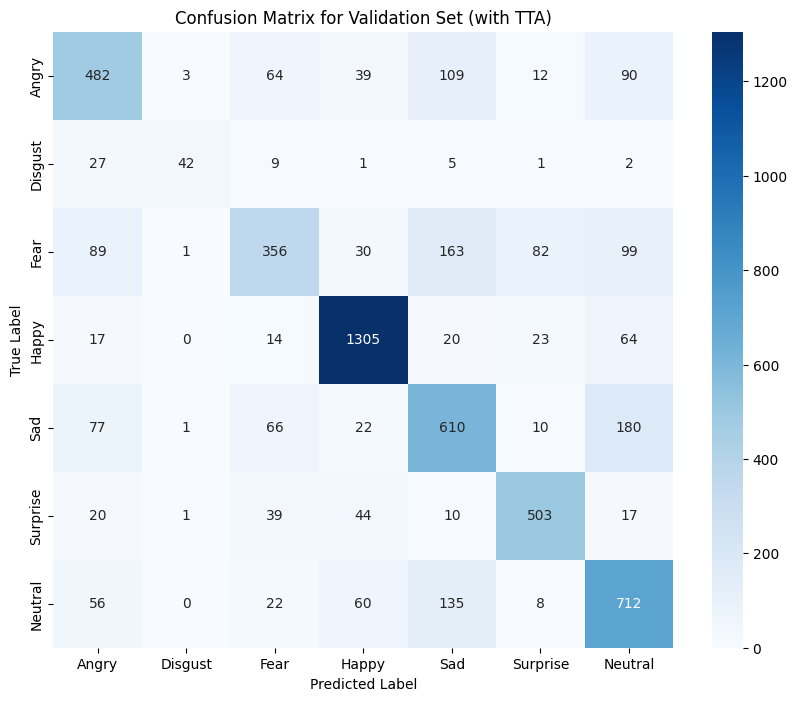

In [23]:
# Cell 8: Model Evaluation (on Validation Set with TTA)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_val_preds = []
all_val_labels = []

with torch.no_grad():
    for images_list, labels in tqdm(val_loader, desc="Evaluating on Validation Set with TTA"):
        labels = labels.to(device)

        tta_outputs = []
        for img_transformed in images_list:
            img_transformed = img_transformed.to(device)
            tta_outputs.append(model(img_transformed))

        # Average the logits (raw outputs) from all TTA transformed images
        avg_outputs = torch.stack(tta_outputs).mean(dim=0)

        _, predicted = torch.max(avg_outputs, 1)
        all_val_preds.extend(predicted.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(all_val_labels, all_val_preds)
print(f"\nValidation Accuracy (with TTA): {val_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_val_labels, all_val_preds, target_names=emotion_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(all_val_labels, all_val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set (with TTA)')
plt.show()

In [24]:
import wandb

run = wandb.init(
    entity="zeliz22-free-university-of-tbilisi-",
    project="Facial Expression Recognition Challenge",
    name="AdvancedEmotionNet",
    tags=["CNN", "facial-expression", "pytorch", "BatchNormalization"],
    config={
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": "Adam",
        "batch_size": batch_size,
        "epochs": 50,
        "image_size": "48x48",
    }
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

run.log({
    "final_train_accuracy": 0.74,
    "final_train_loss": 1,
    "final_val_accuracy": 0.70,
    "final_val_loss": 1,
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),
})

run.finish()

print("Model results logged to WandB successfully!")

final_train_accuracy,▁
final_train_loss,▁
final_val_accuracy,▁
final_val_loss,▁
steps_per_epoch,▁
total_parameters,▁
trainable_parameters,▁
final_train_accuracy,0.74
final_train_loss,1
final_val_accuracy,0.7
final_val_loss,1


Model results logged to WandB successfully!
